# Maratontabellen



### Bakgrund

Den allsvenska maratontabellen, som visar antal matcher, mål, poäng och sådant för alla lag som någonsin spelat i Allsvenskan, är kanske främst något som MFF:are har koll på. Den finns att beskåda på [svenska fotbollförbundets hemsida](https://www.svenskfotboll.se/serier-cuper/elitfotboll/historik-herr/maratontabell/).

Jag önskade mig alltså en graf som visade utvecklingen över tid. MFF leder nu, men hur har det sett ut tidigare?

Det visade sig vara svårt att hitta en sådan graf, så jag tog på mig att göra den.

Lite saker att tänka på:
* fram till säsongen 1990 gav en seger 2 poäng. Tabellen på SvFF:s hemsida har räknat om alla segrar innan 1990 till att ge 3 poäng istället. Det kan man ju tycka vad man vill om, men så är det och det har jag också gjort.
* grafen i sin helhet listar 67 lag över 99 säsonger och visar mest hur det sett ut. En Python-cell längre ner kommer ha kod för den som vill generera en egen graf med valda lag och säsonger.

Nåväl. Här är den!

![Maratontabellen säsong för säsong, 1924/1925-2023](../plots/maratontabellen_1924-2023.png)

Här är också topp 5 sedan 16-lagsserien infördes 2008:

![Maratontabellen topp 5, 2008-2023](../plots/maratontabellen_topp5_2008-2023.png)


In [159]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
from matplotlib.colors import ListedColormap

# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = '#e4e4e4'
plt.rcParams['axes.facecolor'] = '#dedee5'

cmap = ListedColormap(plt.cm.cividis(np.linspace(0, .75, num=70)))


In [38]:
# Import and prepare data

df = pd.read_csv('../data/allsvenskan.csv')
df['3pwin'] = (df.wins*3 + df.draws)
df['ppg_3pwin'] = df['3pwin']/df.games
venues = pd.read_csv('../data/venues.csv')
final_rounds = df.query('final == 1')
since_2008 = df.query(('year >= 2008 and year < 2023'))
final_rounds_since_2008 = since_2008.query('final == 1')
final_rounds_since_2008

,year,round,final,team_id,team_name,position,games,wins,draws,losses,gf,ga,gd,points,3pwin,ppg_3pwin
23674,2008,30,1,34,Kalmar FF,1,30,20,4,6,70,32,38,64,64,2.133333
23675,2008,30,1,15,IF Elfsborg,2,30,19,6,5,49,18,31,63,63,2.100000
23676,2008,30,1,2,IFK Göteborg,3,30,15,9,6,50,26,24,54,54,1.800000
23677,2008,30,1,4,Helsingborgs IF,4,30,16,6,8,54,41,13,54,54,1.800000
23678,2008,30,1,5,AIK,5,30,12,9,9,36,32,4,45,45,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30405,2022,30,1,8,IFK Norrköping,12,30,8,10,12,40,42,-2,34,34,1.133333
30406,2022,30,1,27,Degerfors IF,13,30,7,10,13,32,49,-17,31,31,1.033333
30407,2022,30,1,66,Varbergs BoIS,14,30,8,7,15,31,57,-26,31,31,1.033333
30408,2022,30,1,4,Helsingborgs IF,15,30,4,5,21,22,52,-30,17,17,0.566667


In [ ]:
team = 'Malmö FF'

def team_not_in_season(year):
    print(year.values)

final_rounds.groupby('team_name')['team_id'].value_counts()

In [ ]:
# Point progression per season for every team

points_progression = final_rounds.pivot_table(values='3pwin', index='year', columns='team_name').cumsum()
points_progression.loc[1925].fillna(0, inplace=True)
points_progression.ffill(inplace=True)

In [ ]:
# Plot it

fig, ax = plt.subplots(figsize=(12, 6))
# fig.set_facecolor('#e5e5ee')
# ax.set_facecolor('#e5e5dd')

points_progression.plot(legend=True, colormap=cmap, ax=ax, alpha=.6)
ax.set(title='Poängutveckling herrallsvenskan 1924-2023', xlabel='Säsong', ylabel='Poäng')
ax.legend('')
ax.yaxis.tick_right()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
top5 = points_progression.sort_values(axis='columns', by=2023, ascending=False).columns.values[:5]
points_progression.loc[2008:, top5].plot(title='Allsvenskan topp 5, 2008-2023', ax=ax, colormap=cmap, alpha=.8)
ax.legend(title='')

In [ ]:
no_of_seasons = final_rounds.reset_index()['team_name'].value_counts().to_frame(name='no_of_seasons').reset_index(names='team_name')
total_points = final_rounds.reset_index().groupby('team_name')['points'].sum().sort_index().to_frame().reset_index()
nos_tp = no_of_seasons.merge(total_points, on='team_name')
nos_tp['points_per_season'] = nos_tp.points/nos_tp.no_of_seasons
nos_tp = nos_tp.sort_values('points_per_season', ascending=False)
# nos_tp.hist(bins=25, figsize=(10, 10))
nos_tp.plot(kind='scatter', x='no_of_seasons', y='points_per_season')

In [ ]:
# Maratontabellen animated
# Under reconstruction

def plot(df, start, i):
    plt.cla()
    plt.axes().set_facecolor('gray')
    seasons = (start-5, start+1)
    selected_seasons = slice(*df.index.get_indexer(seasons))
    # df = df.iloc[selected_seasons, selected_teams]
    df.plot(xticks=[], xlim=(start-5, start+5), ylim=(df.loc[start].max()-500, df.loc[start].max()+500), legend='', alpha=0)
    # df.plot(xticks=[], xlim=(start-5, start+5), ylim=(df.loc[start].max()-500, df.loc[start].max()+500), legend='', color=['#a7d7ff', 'darkblue', 'yellow', 'cornflowerblue', 'gold'])
    for r in df:
        team = r
        x = start
        y = df[r][start]
        plt.annotate(team, [x, y], [x, y], alpha=.6)
    plt.annotate(f'{start}', xy=[start+4, df.loc[start].max()+400])
    plt.savefig(f'plots/anim/all_teams/p{i:0>2}.png')
    plt.close()
    i += 1

# for s in range(1930, 2023):
#     plot(df, s, i)
#     i += 1

df

In [ ]:
season = '2023'
dists_df = pd.read_json('data/distances.json')
coords_df = pd.read_json('data/venues.json')
dists = pd.DataFrame(data = dists_df.loc[season].dropna())
dists = dists/15
dists['lat'] = coords_df.lat
dists['lon'] = coords_df.lon

fig = plt.figure(figsize=(15, 10))
m = Basemap(projection = 'merc', llcrnrlat = 54, urcrnrlat = 70, llcrnrlon = 7, urcrnrlon = 25, resolution = 'l')
m.drawcoastlines()
m.drawcountries()
for ((d, lat, lon), c) in zip(dists.values, colors):
    m.scatter(lon, lat, latlon=True, label=None, alpha=.5, s=d, color=c, linewidth=0)
plt.grid()

### Tabeller 2008-2022

In [11]:
final_rounds[['position', 'ppg_3pwin']].corr()

,position,ppg_3pwin
position,1.000000,-0.915644
ppg_3pwin,-0.915644,1.000000


In [41]:
winners = final_rounds_since_2008.query('position == 1')
wins = winners.team_name.value_counts()
wins

Malmö FF           7
AIK                2
Kalmar FF          1
Helsingborgs IF    1
IF Elfsborg        1
IFK Norrköping     1
Djurgårdens IF     1
BK Häcken          1
Name: team_name, dtype: int64

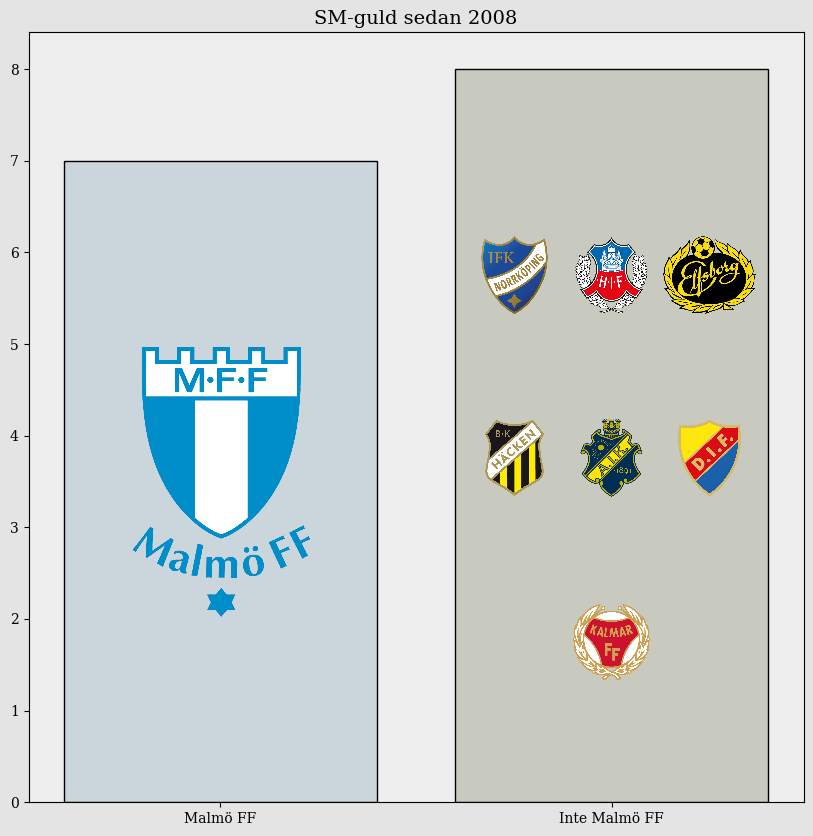

In [42]:
# Vinnare

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams['axes.facecolor'] = '#eee'

def get_logo(name):
    path = f'../img/{name.replace(" ", "_")}.png'
    img = plt.imread(path)
    return img

def offset_image(coords, name, ax, zoom):
    img = get_logo(name)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(im, coords, xybox=coords, frameon=False)

    ax.add_artist(ab)

winners = final_rounds_since_2008.query('position == 1')
# # (winners.points / winners.games).plot(kind='hist', bins=15, title='Poängsnitt för SM-guld 2008-2022');
mff = set(['Malmö FF'])
others = list(set(wins.index) - mff)
# m = winners.team.value_counts().loc['Malmö FF'].sum()
# o = winners.team.value_counts().loc[others].sum()

mff_wins = wins['Malmö FF']
other_wins = wins[wins.index[1:]].sum()

fig, ax = plt.subplots(figsize=(10, 10))

ax.bar([1, 2], [mff_wins, other_wins], color=['#CBD5DC', '#C9CABF'], edgecolor='k')
ax.set_xticks([1, 2], labels=['Malmö FF', 'Inte Malmö FF'])
# ax.set_xlim(0, 3)
# ax.set_ylim(0, 10)
offset_image((1, 3.5), 'Malmö FF', ax, .2)
other_y_start = 5.75
o_coords = [(1.75, other_y_start), (2, other_y_start), (2.25, other_y_start), (1.75, other_y_start-2), (2, other_y_start-2), (2.25, other_y_start-2), (2, other_y_start-4)]
for t, coords in zip(others, o_coords):
    offset_image(coords, t, ax, .1)

plt.title('SM-guld sedan 2008', size=14);


### Efter nuvarande omgång 2008-2022

In [161]:
r = 26
data = []
leaders = since_2008.query('position == 1')
winners = leaders.query('final == 1')
for r in range(1, 30):
    round_leaders = leaders.query(f'round == {r}') 
    data.append((15 - winners.merge(round_leaders, on=['year', 'team_id'], how='outer', indicator=True).query('_merge == "left_only"').team_name_x.count()))


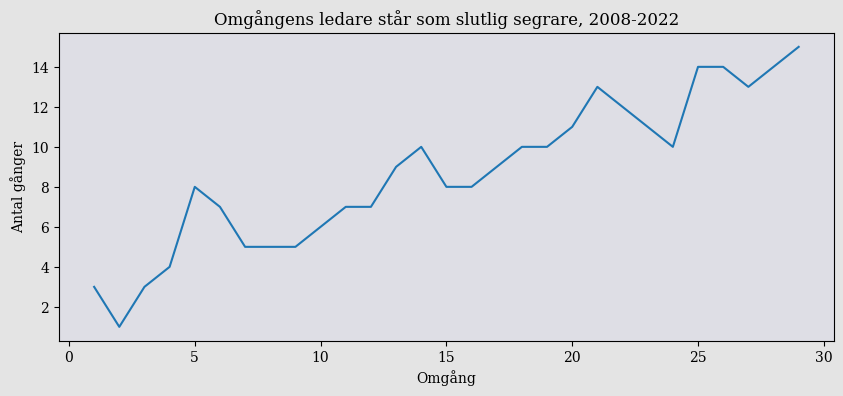

In [162]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(*[range(1, 30), data])
ax.set(title='Omgångens ledare står som slutlig segrare, 2008-2022', xlabel='Omgång', ylabel='Antal gånger');

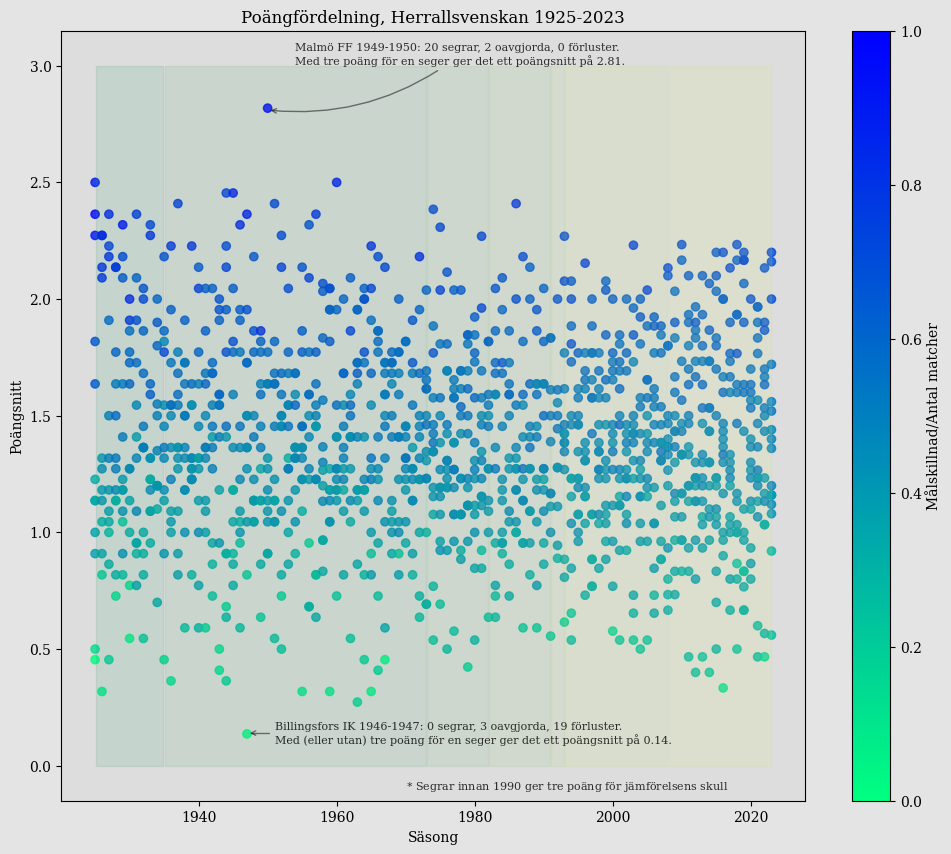

In [45]:
from matplotlib.path import Path

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.facecolor'] = '#ddd'

colors = plt.colormaps['summer'](
    np.linspace(.15, .85, 7)
)


fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(final_rounds.year, final_rounds.ppg_3pwin, alpha=.8, c=(final_rounds.ga-final_rounds.gf)/final_rounds.games, cmap="winter")
ax.set(title='Poängfördelning, Herrallsvenskan 1925-2023', xlabel='Säsong', ylabel='Poängsnitt')
ax.text(1970, -.1, '$*$ Segrar innan 1990 ger tre poäng för jämförelsens skull', size=8, alpha=.8)
ax.annotate('Malmö FF 1949-1950: 20 segrar, 2 oavgjorda, 0 förluster.\nMed tre poäng för en seger ger det ett poängsnitt på 2.81.', (1950, 2.81), xytext=(20, 40), textcoords='offset points', size=8, va='center', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.2', alpha=.5), alpha=.8)
ax.annotate('Billingsfors IK 1946-1947: 0 segrar, 3 oavgjorda, 19 förluster.\nMed (eller utan) tre poäng för en seger ger det ett poängsnitt på 0.14.', (1947, .14), xytext=(20, 0), textcoords='offset points', size=8, va='center', arrowprops=dict(arrowstyle='->', connectionstyle='arc,rad=-.2', alpha=.5), alpha=.8)

years_with_change = [1925, 1935, 1973, 1982, 1991, 1993, 2008]

for c, y in enumerate(years_with_change):
    try:
        ax.fill_betweenx([0, 3], y+.1, years_with_change[c+1]-.1, color=colors[c], alpha=.12)
    except:
        ax.fill_betweenx([0, 3], y+.1, 2023, color=colors[c], alpha=.12)

plt.colorbar(plt.cm.ScalarMappable(cmap='winter_r'), ax=ax, label='Målskillnad/Antal matcher')


<Axes: title={'center': 'Poängsnitt för serieseger 1925-2022'}, xlabel='Säsong', ylabel='Poängsnitt seriesegrare'>

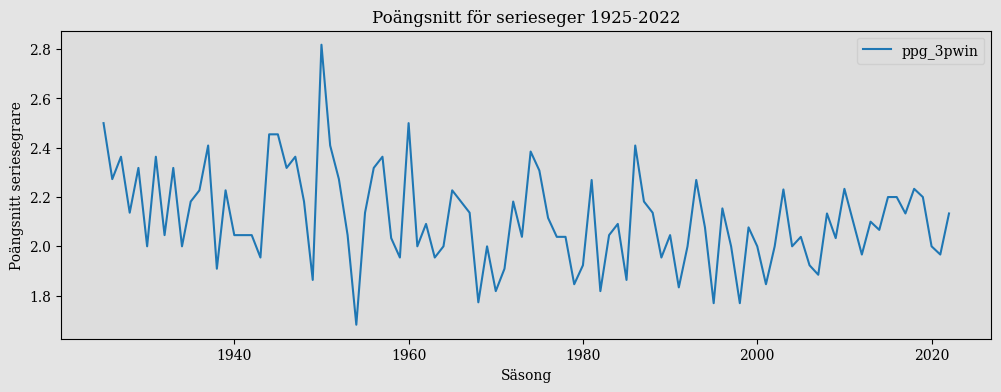

In [86]:
fig, ax = plt.subplots(figsize=(12, 4))
final_rounds.query('year <= 2022 and position == 1')[['year', 'ppg_3pwin']].plot(x='year', title='Poängsnitt för serieseger 1925-2022', xlabel='Säsong', ylabel='Poängsnitt seriesegrare', ax=ax)

In [53]:
no_of_team_changed = final_rounds.groupby('year')['team_name'].count().diff().fillna(0) != 0
for y in no_of_team_changed[no_of_team_changed].index.values:
    print(y, final_rounds.query(f'year == {y}').position.max())


1934 11
1935 12
1973 14
1982 12
1991 10
1993 14
2008 16


In [59]:
df.groupby('year').position.apply(max)

year
1925    12
1926    12
1927    12
1928    12
1929    12
        ..
2019    16
2020    16
2021    16
2022    16
2023    16
Name: position, Length: 99, dtype: int64

In [ ]:
# final_rounds = final_rounds.reset_index()
final_rounds[final_rounds.team == 'BK Häcken'].position.diff().fillna(0).plot()
# final_rounds.reset_index()

In [ ]:
final_rounds['gd'] = final_rounds.gf-final_rounds.ga
final_rounds.loc[2016]

In [ ]:
data = [('BK Häcken', 50),
('Hammarby IF', 49),
('Linköpings FC', 48),
('Vittsjö GIK | Piteå IF', 43),
('Kristianstads DFF', 39),
('FC Rosengård', 38),
('Djurgårdens IF', 22),
('IFK Norrköping | KIF Örebro', 20),
('Växjö DFF', 19),
('IK Uppsala Fotboll', 13),
('IF Brommapojkarna', 11),
('IFK Kalmar', 3)]

fig, ax = plt.subplots(figsize=(5, 10))
for row in data:
    ax.text(.2, row[1], row[0])
ax.set(xlim=(0, 1), ylim=(1, 55), xticklabels=[], title='Damallsvenskan 2023 omg. 21/22')